# 01 Data Preparation

**Assignment 1: Data Foundation**

- Load raw review.json (JSONL) into SQLite
- Filter to **latest 5 years** (assignment requirement)
- Ensure **50,000–80,000+ reviews** after filtering
- Create **reviews_sample.db** with 5,000+ reviews for TAs
- Document schema and indexing

In [1]:
# Setup: find project root (dir containing "src") and add to path
import sys
from pathlib import Path
project_root = Path.cwd().resolve()
while project_root != project_root.parent and not (project_root / "src").exists():
    project_root = project_root.parent
sys.path.insert(0, str(project_root))

from src.utils import get_engine, get_db_path
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_theme(style="whitegrid")


## 1. Full load (run once)

Full ETL streams review.json line-by-line into data/reviews.db. Run from project root:
```bash
python -m src.data_processing --full-etl --target-reviews 80000
```

Note: ETL should be run from project root to write to data/reviews.db.


In [2]:
# Connect to full DB (or sample if full not present)
sample_path = get_db_path(sample=True)
full_path = get_db_path(sample=False)
use_sample = not full_path.exists()

engine = get_engine(sample=use_sample)
print(f"Using: {'sample' if use_sample else 'full'} DB")

Using: full DB


## 2. Data volume and quick checks

This confirms review volume, basic schema access, and provides a top-10 snapshot for the report.


In [3]:
# Data volume and schema check
n_reviews = pd.read_sql("SELECT COUNT(*) AS n FROM reviews", engine).iloc[0]["n"]
n_authors = pd.read_sql("SELECT COUNT(*) AS n FROM authors", engine).iloc[0]["n"]
n_hotels = pd.read_sql("SELECT COUNT(DISTINCT offering_id) AS n FROM reviews", engine).iloc[0]["n"]
print(f"Reviews: {n_reviews:,} | Authors: {n_authors:,} | Hotels: {n_hotels:,}")
pd.read_sql("SELECT * FROM reviews LIMIT 2", engine)

# Summary: top 10 hotels by review count (for report)
pd.read_sql("""SELECT offering_id, COUNT(*) AS n_reviews, ROUND(AVG(rating_overall), 2) AS avg_rating FROM reviews GROUP BY offering_id ORDER BY n_reviews DESC LIMIT 10""", engine)

Reviews: 79,853 | Authors: 71,266 | Hotels: 3,374


,offering_id,n_reviews,avg_rating
0,214197,453,2.58
1,122005,367,4.01
2,93520,355,3.63
3,99766,324,3.54
4,93618,316,3.94
5,93437,296,3.53
6,99352,281,4.54
7,93562,278,4.03
8,223023,270,3.18
9,93507,254,4.20


## 3. Review distribution by year



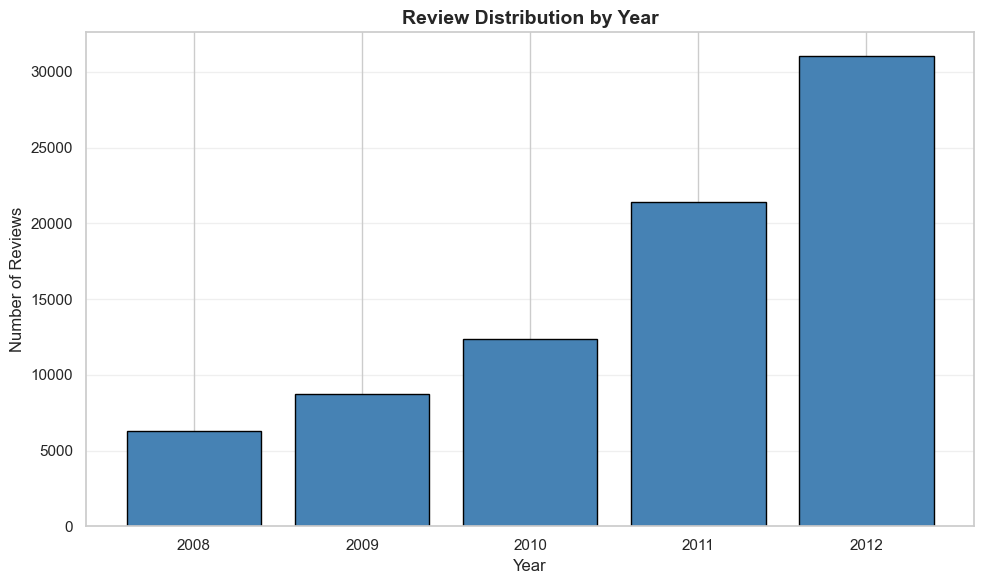

 year  count
 2008   6280
 2009   8717
 2010  12396
 2011  21397
 2012  31063


In [5]:
year_dist = pd.read_sql("""
    SELECT 
        CAST(SUBSTR(TRIM(date), -4) AS INTEGER) AS year,
        COUNT(*) as count
    FROM reviews
    WHERE date IS NOT NULL AND LENGTH(TRIM(date)) >= 4
    GROUP BY year
    ORDER BY year
""", engine)

fig, ax = plt.subplots(figsize=(10, 6))
ax.bar(year_dist['year'], year_dist['count'], color='steelblue', edgecolor='black')
ax.set_xlabel('Year', fontsize=12)
ax.set_ylabel('Number of Reviews', fontsize=12)
ax.set_title('Review Distribution by Year', fontsize=14, fontweight='bold')
ax.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print(year_dist.to_string(index=False))

## 4. Create sample DB (5,000+ reviews for TAs)

Run from project root: `python -m src.data_processing`


In [6]:
from src.data_processing import build_sample_db
try:
    path = build_sample_db(sample_size=5000)
    print(f"Created {path}")
    import sqlite3
    with sqlite3.connect(str(sample_path)) as conn:
        n = conn.execute("SELECT COUNT(*) FROM reviews").fetchone()[0]
    print(f"   Sample DB has {n:,} reviews")
except FileNotFoundError as e:
    print("Run: python -m src.data_processing --full-etl first.", e)

Created C:\Users\rayya\Desktop\IS5126-G4-hotel-analytics-master\data\reviews_sample.db
   Sample DB has 5,000 reviews
